FAKE_TORINO: P(final) = {'0': 0.655, '1': 0.345}


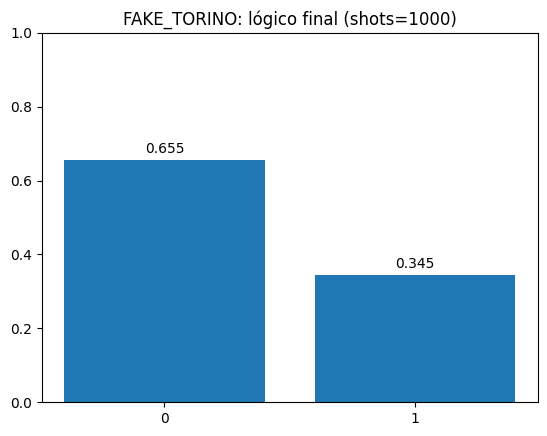

Tiempo total: 7.57s


In [3]:
# -*- coding: utf-8 -*-
# Requisitos:
#   pip install "qiskit>=2.1" "qiskit-aer>=0.14" "qiskit-ibm-runtime" matplotlib

import os, math, time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.primitives import BackendSamplerV2
from qiskit_ibm_runtime.fake_provider import FakeTorino

# ========= Parámetros =========
USE_NOISE   = True
P1          = 3e-4
P2          = 3e-3
PM          = 1e-2
SHOTS       = 1_000
SEED_SIM    = 1234
THETA       = 1.2310                     # ~66/33
GRAFICAR    = "FAKE_TORINO"              # "SIN_RUIDO" | "CON_RUIDO" | "FAKE_TORINO"

# ========= Ruido (solo si CON_RUIDO) =========
def build_noise_model(p1, p2, pm) -> NoiseModel:
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p1, 1),
        ['x','y','z','h','s','sdg','t','tdg','rx','ry','rz','sx'])
    noise.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    ro = ReadoutError([[1-pm, pm],[pm,1-pm]])
    noise.add_all_qubit_readout_error(ro)
    return noise

# ========= Construcción del circuito (solo puertas) =========
def build_circuit(theta: float = THETA) -> QuantumCircuit:
    # Registros
    q_data  = QuantumRegister(9, 'data')
    c_final = ClassicalRegister(1, 'final')
    qc = QuantumCircuit(q_data, c_final, name='shor9_gates_only')

    # ---------- Encoding (Shor-9 estándar) ----------
    qc.ry(theta, q_data[0])                # estado lógico inicial

    # Repetición entre bloques
    qc.cx(q_data[0], q_data[3])
    qc.cx(q_data[0], q_data[6])

    # A base X en centros de bloque
    qc.h(q_data[0]); qc.h(q_data[3]); qc.h(q_data[6])

    # Repetición interna (en cada bloque)
    qc.cx(q_data[0], q_data[1]); qc.cx(q_data[0], q_data[2])
    qc.cx(q_data[3], q_data[4]); qc.cx(q_data[3], q_data[5])
    qc.cx(q_data[6], q_data[7]); qc.cx(q_data[6], q_data[8])

    qc.barrier(label="encode")

    # ---------- "Decodificación"/recuperación por mayoría (sin síndromes) ----------
    # 1) Corrige bit-flip en cada triplete (mayoría en Z)
    qc.cx(q_data[0], q_data[1]); qc.cx(q_data[0], q_data[2])
    qc.cx(q_data[3], q_data[4]); qc.cx(q_data[3], q_data[5])
    qc.cx(q_data[6], q_data[7]); qc.cx(q_data[6], q_data[8])

    qc.ccx(q_data[1], q_data[2], q_data[0])  # bloque 0-1-2
    qc.ccx(q_data[4], q_data[5], q_data[3])  # bloque 3-4-5
    qc.ccx(q_data[7], q_data[8], q_data[6])  # bloque 6-7-8

    # 2) Cambia base para corregir fase (Z) a mayoría entre los 3 centros
    qc.h(q_data[0]); qc.h(q_data[3]); qc.h(q_data[6])

    # 3) Mayoría entre centros (0,3,6)
    qc.cx(q_data[0], q_data[3]); qc.cx(q_data[0], q_data[6])
    qc.ccx(q_data[3], q_data[6], q_data[0])

    qc.barrier(label="decode")

    # Medida del lógico final
    qc.measure(q_data[0], c_final[0])

    return qc

# ========= Sampler y utilidades =========
def run_sampler(circ: QuantumCircuit, backend, shots: int) -> Counter:
    sampler = BackendSamplerV2(backend=backend)
    res = sampler.run([circ], shots=shots).result()[0]
    return Counter(res.join_data().get_counts())

def marginalize_single_bit(circ: QuantumCircuit, counts: Counter, clbit) -> dict:
    # Robusto a claves con espacios
    idx = circ.clbits.index(clbit)
    tot = sum(counts.values())
    p1 = 0
    for k, c in counts.items():
        if not isinstance(k, str):
            continue
        bits = ''.join(ch for ch in k if ch in '01')
        if len(bits) <= idx:
            continue
        if bits[-1 - idx] == '1':
            p1 += c
    p1 /= (tot if tot else 1)
    return {'0': 1 - p1, '1': p1}

def plot_probs(probs: dict, title: str):
    plt.bar(list(probs.keys()), list(probs.values()))
    plt.ylim(0, 1)
    for x, v in probs.items():
        plt.text(x, min(1.0, v+0.02), f"{v:.3f}", ha='center')
    plt.title(title); plt.show()

# ========= Main =========
def main(graficar: str):
    qc = build_circuit(theta=THETA)
    n_threads = max(1, math.floor(os.cpu_count() / 3))

    if graficar == "SIN_RUIDO":
        backend = AerSimulator(method="automatic", seed_simulator=SEED_SIM)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED_SIM)
        counts = run_sampler(qc_t, backend, SHOTS)

    elif graficar == "CON_RUIDO":
        noise = build_noise_model(P1, P2, PM)
        backend = AerSimulator(method="automatic", noise_model=noise, seed_simulator=SEED_SIM)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, basis_gates=noise.basis_gates,
                         optimization_level=3, seed_transpiler=SEED_SIM)
        counts = run_sampler(qc_t, backend, SHOTS)

    elif graficar == "FAKE_TORINO":
        fake = FakeTorino()
        backend = AerSimulator.from_backend(fake, seed_simulator=SEED_SIM)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED_SIM)
        counts = run_sampler(qc_t, backend, SHOTS)

    else:
        raise ValueError("graficar debe ser 'SIN_RUIDO', 'CON_RUIDO' o 'FAKE_TORINO'.")

    probs = marginalize_single_bit(qc_t, counts, qc_t.cregs[-1][0])  # 'final'[0]
    print(f"{graficar}: P(final) = {probs}")
    plot_probs(probs, f"{graficar}: lógico final (shots={SHOTS})")

if __name__ == "__main__":
    t0 = time.time()
    main(GRAFICAR)
    print(f"Tiempo total: {time.time() - t0:.2f}s")

